In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

%load_ext line_profiler
%matplotlib inline

torch.set_default_tensor_type(torch.DoubleTensor)

import os, sys 
device = torch.device('cuda:0') #if torch.cuda.is_available() else 
# device = torch.device("cpu")


### testing direct vs first reaction

In [3]:
from circuits.mrna_srna.mrna_srna_intrans import mRNAsRNAInTrans, cfg

from ssa_solvers.simulators import StochasticSimulator, DeterministicSimulator 
from ssa_solvers.data_class import SimulationData

end_time = 300
n_steps = 300
n_traj = 20000


In [4]:
reaction_system = mRNAsRNAInTrans(device=device)
init_pops = torch.zeros((reaction_system.n_species, ), dtype=torch.int64, device=device) #torch.randint(1, (reaction_system.n_species, ))
time_grid_np = np.arange(0, end_time, int(end_time / n_steps))
time_grid_torch = torch.from_numpy(time_grid_np).to(device)

# Specifying a simulator using direct method
cfg['solver'] = 'direct'
data_set_direct = SimulationData(device=device)
ssa_simulator_direct = StochasticSimulator(
    reaction_system=reaction_system,
    data_set=data_set_direct,
    cfg=cfg,
    device=device
)
# Specifying a simulator using first reaction method
cfg['solver'] = 'first_reaction'
data_set_fr = SimulationData(device=device)
ssa_simulator_fr = StochasticSimulator(
    reaction_system=reaction_system,
    data_set=data_set_fr,
    cfg=cfg,
    device=device
)

In [5]:
%timeit ssa_simulator_fr.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)
%timeit ssa_simulator_direct.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)

691 ms ± 38.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
707 ms ± 56.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Parameters for deterministic simulations 

In [8]:
reaction_system = mRNAsRNAInTrans()
ode_simulator = DeterministicSimulator(
    reaction_system=reaction_system,
    cfg=cfg
)
init_pops = np.zeros((reaction_system.n_species,))
time_grid_np = np.arange(0, end_time, int(end_time / n_steps))
ode_res = ode_simulator.simulate(init_pops=init_pops, time_grid=time_grid_np)

### Plotting results for verification

Comptuting the statistics on a grid

In [9]:
means_direct = data_set_direct.mean(time_range=time_grid_torch)
stds_direct = data_set_direct.std(time_range=time_grid_torch)
cov_direct = data_set_direct.coefficient_of_variation(time_range=time_grid_torch)

means_fr = data_set_fr.mean(time_range=time_grid_torch)
stds_fr = data_set_fr.std(time_range=time_grid_torch)
cov_fr = data_set_fr.coefficient_of_variation(time_range=time_grid_torch)

/home/aivar/projects/ssa-solvers/ssa_solvers/data_class.py:97: RuntimeWarning: invalid value encountered in true_divide
  return  self.std(species_idxs, time_range) / self.mean(species_idxs, time_range)


Plotting

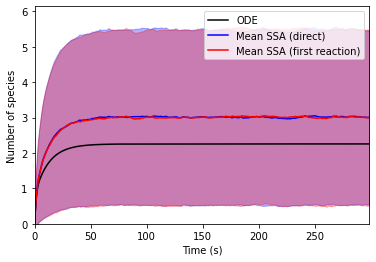

In [12]:
species_idx = 1
plt.figure()
# ode
plt.plot(time_grid_np, ode_res[species_idx, :], 'k', label='ODE')
# direct ssa 
plt.plot(time_grid_np, means_direct[species_idx, :], 'b', label='Mean SSA (direct)')
plt.fill_between(time_grid_np, means_direct[species_idx,:]+stds_direct[species_idx, :], means_direct[species_idx,:]-stds_direct[species_idx, :], 
                 color='b', alpha=0.3)
plt.xlim([0, end_time])    

plt.xlabel('Time (s)')
plt.ylabel('Number of species')
# first reaction ssa
plt.plot(time_grid_np, means_fr[species_idx, :], 'r', label='Mean SSA (first reaction)')
plt.fill_between(time_grid_np, means_fr[species_idx,:]+stds_fr[species_idx, :], means_fr[species_idx,:]-stds_fr[species_idx, :], 
                 color='r',alpha=0.3)
plt.xlim([0, end_time])    
plt.xlabel('Time (s)')
plt.ylabel('Number of species')
plt.xlim([0, max(time_grid_np)])
plt.ylim([0, 1.1 * max([(means_direct[species_idx,:]+stds_direct[species_idx, :]).max(), 
                        (means_fr[species_idx,:]+stds_fr[species_idx, :]).max()])])
plt.legend()

### CPU vs GPU

In [13]:
from circuits.auto_repressor.tetr_srna_incis import TetRsRNAInCis, cfg

cfg['solver'] = 'direct'
device = torch.device("cuda:0")
reaction_system_c = TetRsRNAInCis(device=device)
init_pops_c = torch.zeros((reaction_system_c.n_species, ), dtype=torch.int64, device=device) 
data_set_c = SimulationData(device=device)
ssa_simulator_c = StochasticSimulator(
    reaction_system=reaction_system_c,
    data_set=data_set_c,
    cfg=cfg,
    device=device
)

device = torch.device("cpu")
reaction_system = TetRsRNAInCis(device=device)
init_pops = torch.zeros((reaction_system.n_species, ), dtype=torch.int64, device=device) 
data_set = SimulationData(device=device)
ssa_simulator = StochasticSimulator(
    reaction_system=reaction_system,
    data_set=data_set,
    cfg=cfg,
    device=device
)

In [14]:
n_traj = 100000
%timeit ssa_simulator_c.simulate(init_pops=init_pops_c, end_time=end_time, n_trajectories=n_traj)
%timeit ssa_simulator.simulate(init_pops=init_pops, end_time=end_time, n_trajectories=n_traj)

477 ms ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5.89 s ± 1.42 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
